# ViTs vs CNNs

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir("/content/drive/MyDrive/cat_dog")


['test_class_labels.txt',
 'train_class_labels.txt',
 'AugmentImages.py',
 'train_data.csv',
 'augmented_data.csv',
 'test_data.csv',
 'Untitled.ipynb',
 'augmented',
 '.ipynb_checkpoints',
 'train',
 'test',
 'Assignment1b_Group16.ipynb',
 'Copy of Assignment1b_Group16.ipynb',
 'DM_MT_Code.ipynb',
 'Untitled0.ipynb',
 'Copy of Untitled0.ipynb',
 'Copy of Copy of Assignment1b_Group16.ipynb',
 'archive.zip',
 'images',
 'structured',
 'iiit_pet_multiclass.csv',
 'best_vit_multiclass.pth',
 'best_vit_scratch_80.pth',
 'GROUP-16.ipynb',
 'best_vit.pth',
 'best_resnet.pth',
 'Copy of Copy of Untitled0.ipynb']

# Dataset Loading and Splitting

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load full dataset
csv_path = "/content/drive/MyDrive/cat_dog/iiit_pet_multiclass.csv"
df = pd.read_csv(csv_path)

# Split 10% test
trainval_df, test_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=42)

# Split 10% val from trainval
train_df, val_df = train_test_split(trainval_df, test_size=0.1, stratify=trainval_df['class'], random_state=42)

# Confirm splits
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 5985, Val: 665, Test: 739


# Data Augmentation and Normalization

In [4]:
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),  # 🎯 Tuned RandAugment
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    


# Custom Dataset Definition

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class PetDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        classes = sorted(self.data['class'].unique())
        self.label_map = {label: idx for idx, label in enumerate(classes)}
        self.inverse_map = {v: k for k, v in self.label_map.items()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.label_map[self.data.iloc[idx, 1]]
        if self.transform:
            image = self.transform(image)
        return image, label


# Dataset and DataLoader Initialization

In [6]:
image_root = '/content/drive/MyDrive/cat_dog/images'
num_classes = df['class'].nunique()

# Create datasets
train_dataset = PetDataset(train_df, root_dir=image_root, transform=train_transform)
val_dataset   = PetDataset(val_df, root_dir=image_root, transform=val_transform)
test_dataset  = PetDataset(test_df, root_dir=image_root, transform=val_transform)

# Dataloaders (adjust batch_size if needed)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Dataset Sample Inspection

In [7]:
image, label = train_dataset[0]
print(image.shape, label)


torch.Size([3, 224, 224]) 10


# Visualizing Sample Training Images

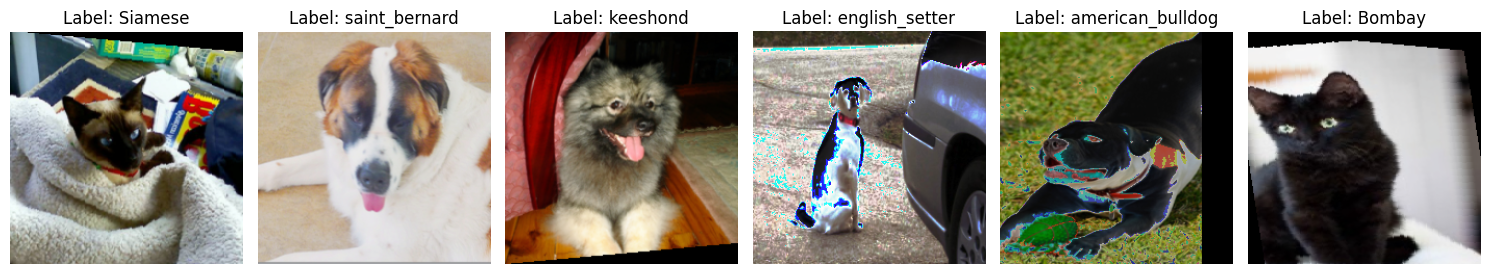

In [8]:
import matplotlib.pyplot as plt

# Reverse class mapping
idx_to_class = {v: k for k, v in train_dataset.label_map.items()}

# Function to show N images from a dataset
def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image_np = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image_np = image_np.clip(0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f"Label: {idx_to_class[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show samples from train set
show_sample_images(train_dataset)


# Vision Transformer (ViT) Model Setup

In [9]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn
import torch

# 1. Load pretrained model
weights = ViT_B_16_Weights.DEFAULT
vit_model = vit_b_16(weights=weights)

# 2. Unfreeze all layers
for param in vit_model.parameters():
    param.requires_grad = True

# 3. Replace classification head
in_features = vit_model.heads[0].in_features
vit_model.heads = nn.Sequential(nn.Linear(in_features, num_classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Move to device
vit_model = vit_model.to(device)

# 5. Define optimizer AFTER modifying model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = vit_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=3e-4, weight_decay=0.01)

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


# Load and Customize Pretrained ResNet34

In [11]:
from torchvision.models import resnet34, ResNet34_Weights

# Load pretrained ResNet34
resnet_model = resnet34(weights=ResNet34_Weights.DEFAULT)

# Replace the final fully connected layer
in_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features, num_classes)


# Configure ResNet Training Setup

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

resnet_model = resnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=3e-4, weight_decay=0.01)

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


# Early Stopping Class

In [13]:
class EarlyStopping:
    def __init__(self, patience=0):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Inspecting Training Batch

In [14]:
for images, labels in train_loader:
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break


Labels shape: torch.Size([32])
Labels dtype: torch.int64


# Trainable Parameters in ViT Model

In [15]:
print("Trainable parameters:", sum(p.numel() for p in vit_model.parameters() if p.requires_grad))


Trainable parameters: 85827109


# Trainable Parameters in ResNet Model

In [ ]:
print("Trainable parameters:", sum(p.numel() for p in resnet_model.parameters() if p.requires_grad))


# Model Training Loop

In [16]:
def train_model(model, model_name, train_loader, val_loader, optimizer, scheduler, epochs=50):
    model = model.to(device)
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=6)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        # ⏺ Store for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"📉 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"/content/drive/MyDrive/cat_dog/best_{model_name}.pth")
            print(f"💾 Best {model_name} saved (Val Acc: {val_acc:.4f})")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("⏹️ Early stopping triggered.")
            break

        scheduler.step()

    # ⏎ Return the model and metrics
    return model, train_losses, val_losses, val_accuracies


# Training ViT

In [18]:
# Redefine optimizer and scheduler (since the model was already trained once and optimizer state lost)
vit_optimizer = torch.optim.AdamW(vit_model.parameters(), lr=1e-4, weight_decay=0.01)
vit_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(vit_optimizer, T_0=10, T_mult=2)

# Now call the training function to get training history
vit_model, vit_train_losses, vit_val_losses, vit_val_accuracies = train_model(
    vit_model, "vit", train_loader, val_loader, vit_optimizer, vit_scheduler
)


📉 Epoch 1: Train Loss=0.7567, Val Loss=0.4679, Val Acc=0.8526
💾 Best vit saved (Val Acc: 0.8526)
📉 Epoch 2: Train Loss=0.3073, Val Loss=0.3799, Val Acc=0.8752
💾 Best vit saved (Val Acc: 0.8752)
📉 Epoch 3: Train Loss=0.2141, Val Loss=0.4129, Val Acc=0.8722
📉 Epoch 4: Train Loss=0.1522, Val Loss=0.3880, Val Acc=0.8932
💾 Best vit saved (Val Acc: 0.8932)
📉 Epoch 5: Train Loss=0.1391, Val Loss=0.3698, Val Acc=0.8887
📉 Epoch 6: Train Loss=0.0663, Val Loss=0.3039, Val Acc=0.9188
💾 Best vit saved (Val Acc: 0.9188)
📉 Epoch 7: Train Loss=0.0405, Val Loss=0.2452, Val Acc=0.9308
💾 Best vit saved (Val Acc: 0.9308)
📉 Epoch 8: Train Loss=0.0249, Val Loss=0.2692, Val Acc=0.9263
📉 Epoch 9: Train Loss=0.0145, Val Loss=0.2358, Val Acc=0.9338
💾 Best vit saved (Val Acc: 0.9338)
📉 Epoch 10: Train Loss=0.0096, Val Loss=0.2360, Val Acc=0.9414
💾 Best vit saved (Val Acc: 0.9414)
📉 Epoch 11: Train Loss=0.2695, Val Loss=0.7239, Val Acc=0.7955
📉 Epoch 12: Train Loss=0.4055, Val Loss=0.4438, Val Acc=0.8722
📉 Epoch 

# Training ResNet

In [19]:
resnet_optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=3e-4, weight_decay=0.01)
resnet_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(resnet_optimizer, T_0=10, T_mult=2)

# ✅ Train the model again and capture history
resnet_model, resnet_train_losses, resnet_val_losses, resnet_val_accuracies = train_model(
    resnet_model, "resnet", train_loader, val_loader, resnet_optimizer, resnet_scheduler
)


📉 Epoch 1: Train Loss=1.1149, Val Loss=0.7751, Val Acc=0.7459
💾 Best resnet saved (Val Acc: 0.7459)
📉 Epoch 2: Train Loss=0.7028, Val Loss=0.6197, Val Acc=0.8060
💾 Best resnet saved (Val Acc: 0.8060)
📉 Epoch 3: Train Loss=0.4989, Val Loss=0.6871, Val Acc=0.7895
📉 Epoch 4: Train Loss=0.3669, Val Loss=0.5692, Val Acc=0.8135
💾 Best resnet saved (Val Acc: 0.8135)
📉 Epoch 5: Train Loss=0.2976, Val Loss=0.4802, Val Acc=0.8496
💾 Best resnet saved (Val Acc: 0.8496)
📉 Epoch 6: Train Loss=0.1950, Val Loss=0.4278, Val Acc=0.8722
💾 Best resnet saved (Val Acc: 0.8722)
📉 Epoch 7: Train Loss=0.1455, Val Loss=0.3403, Val Acc=0.9023
💾 Best resnet saved (Val Acc: 0.9023)
📉 Epoch 8: Train Loss=0.0983, Val Loss=0.3322, Val Acc=0.9098
💾 Best resnet saved (Val Acc: 0.9098)
📉 Epoch 9: Train Loss=0.0731, Val Loss=0.3238, Val Acc=0.9038
📉 Epoch 10: Train Loss=0.0549, Val Loss=0.3005, Val Acc=0.9098
📉 Epoch 11: Train Loss=0.4993, Val Loss=0.8123, Val Acc=0.7759
📉 Epoch 12: Train Loss=0.4424, Val Loss=0.8615, Va

# Evaluating ViT Model on Test Set

In [20]:
import torch
from sklearn.metrics import accuracy_score

# Load and move ViT model
vit_model.load_state_dict(torch.load("/content/drive/MyDrive/cat_dog/best_vit.pth"))
vit_model = vit_model.to(device)
vit_model.eval()

# Evaluate on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vit_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

from sklearn.metrics import accuracy_score
vit_test_acc = accuracy_score(all_labels, all_preds)
print(f"✅ ViT Test Accuracy: {vit_test_acc:.4f}")


✅ ViT Test Accuracy: 0.9310


# Evaluating ResNet Model on Test Set

In [21]:


# Load and move ResNet model
resnet_model.load_state_dict(torch.load("/content/drive/MyDrive/cat_dog/best_resnet.pth"))
resnet_model = resnet_model.to(device)
resnet_model.eval()

# Evaluate on test set
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet_model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

resnet_test_acc = accuracy_score(all_labels, all_preds)
print(f"✅ ResNet Test Accuracy: {resnet_test_acc:.4f}")


✅ ResNet Test Accuracy: 0.9161


# Plotting ViT Training and Validation Metrics

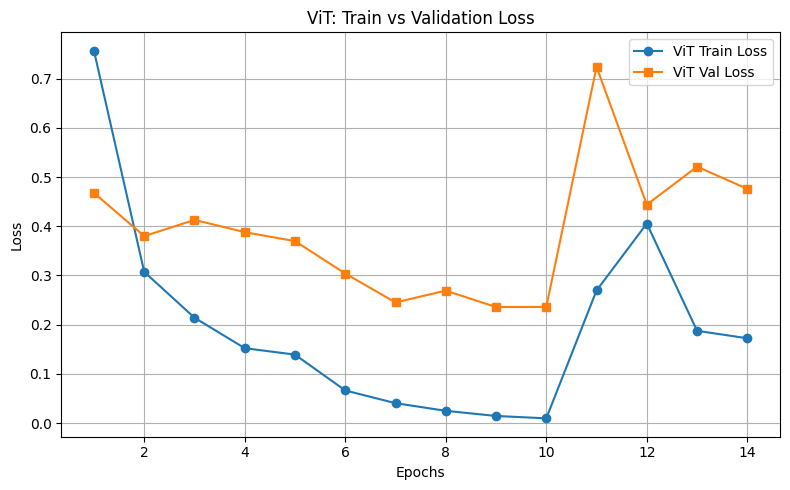

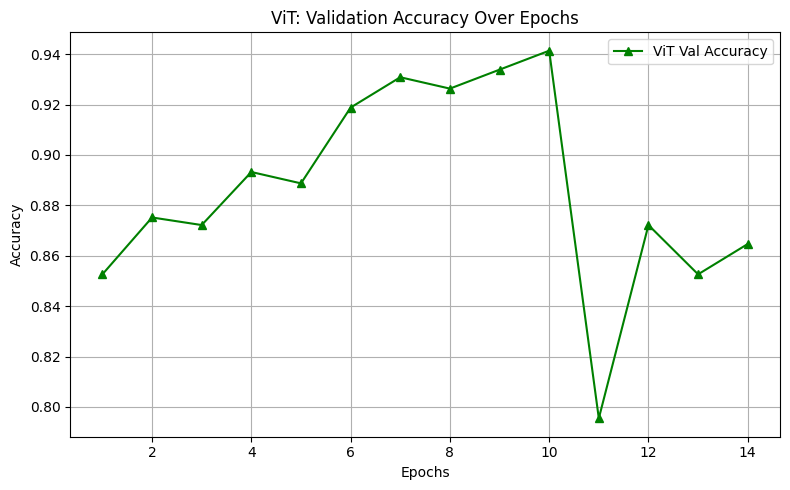

In [22]:
import matplotlib.pyplot as plt

vit_epochs = range(1, len(vit_train_losses) + 1)

# 📉 ViT Loss
plt.figure(figsize=(8, 5))
plt.plot(vit_epochs, vit_train_losses, label='ViT Train Loss', marker='o')
plt.plot(vit_epochs, vit_val_losses, label='ViT Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ViT: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vit_loss_plot.png")
plt.show()

# ✅ ViT Accuracy
plt.figure(figsize=(8, 5))
plt.plot(vit_epochs, vit_val_accuracies, label='ViT Val Accuracy', color='green', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ViT: Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("vit_accuracy_plot.png")
plt.show()


# Plotting ResNet Training and Validation Metrics

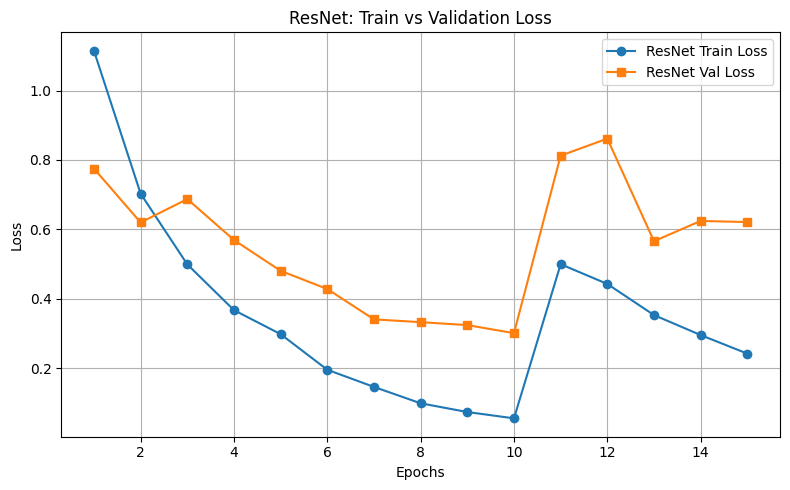

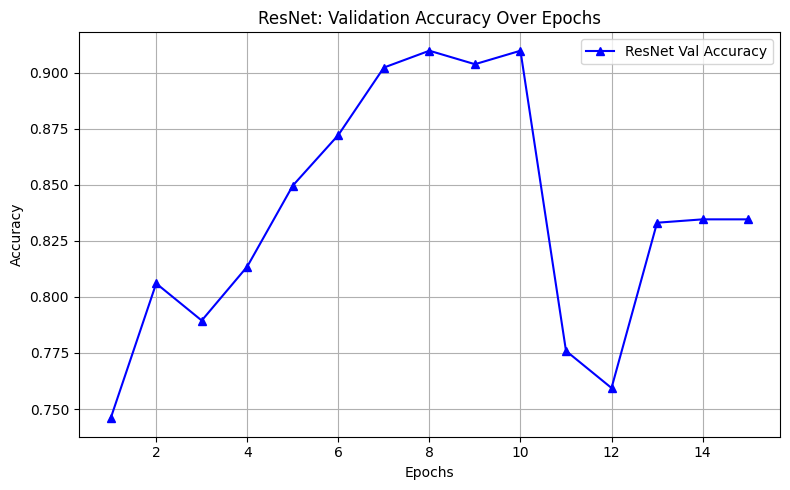

In [23]:
resnet_epochs = range(1, len(resnet_train_losses) + 1)

# 📉 ResNet Loss
plt.figure(figsize=(8, 5))
plt.plot(resnet_epochs, resnet_train_losses, label='ResNet Train Loss', marker='o')
plt.plot(resnet_epochs, resnet_val_losses, label='ResNet Val Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet: Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resnet_loss_plot.png")
plt.show()

# ✅ ResNet Accuracy
plt.figure(figsize=(8, 5))
plt.plot(resnet_epochs, resnet_val_accuracies, label='ResNet Val Accuracy', color='blue', marker='^')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ResNet: Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resnet_accuracy_plot.png")
plt.show()


# Sample Predictions from the Trained ViT Model

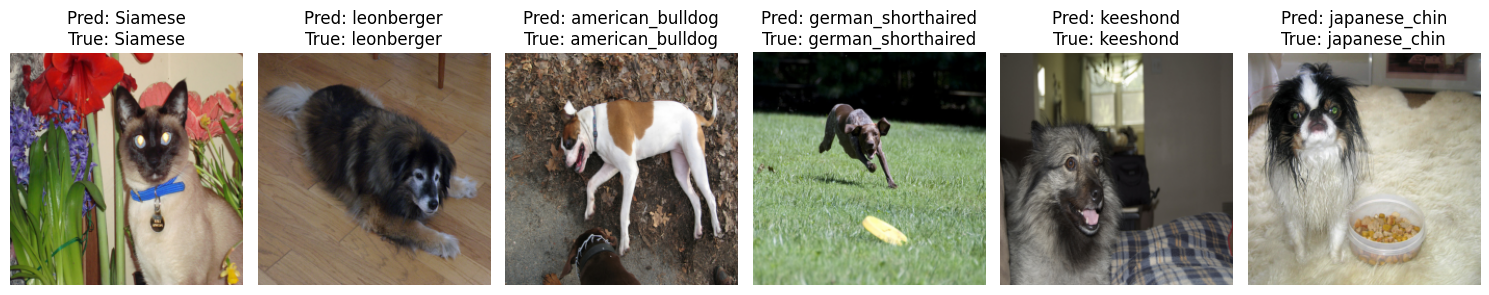

In [24]:
def show_model_predictions(model, dataset, num_images=6):
    model.eval()
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, true_label = dataset[i]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_input)
            pred_label = torch.argmax(outputs, dim=1).item()
        image_np = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image_np = image_np.clip(0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions from ViT model
show_model_predictions(vit_model, test_dataset)


# Sample Predictions from the Trained ResNet Model

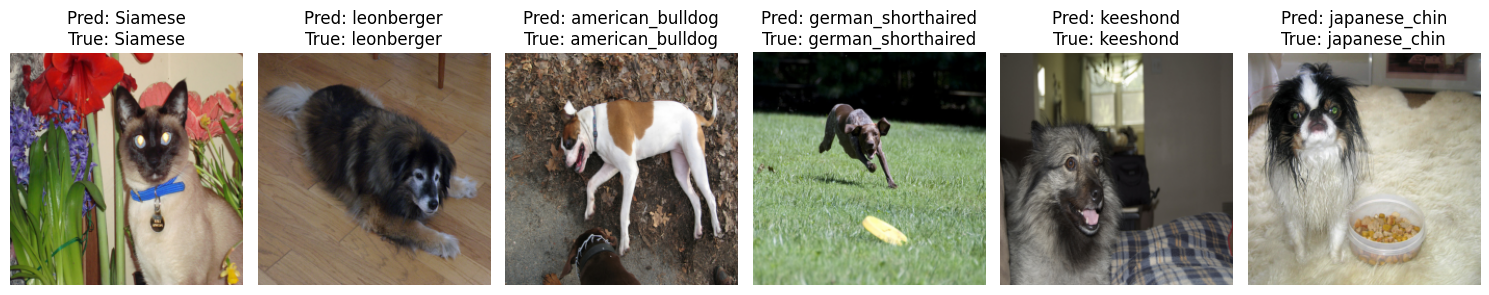

In [25]:
def show_model_predictions(model, dataset, num_images=6):
    model.eval()
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        image, true_label = dataset[i]
        image_input = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_input)
            pred_label = torch.argmax(outputs, dim=1).item()
        image_np = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        image_np = image_np.clip(0, 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f"Pred: {idx_to_class[pred_label]}\nTrue: {idx_to_class[true_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions from ViT model
show_model_predictions(resnet_model, test_dataset)


# Accuracy, Classification Report & Confusion Matrix



In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import torch

def evaluate_model(model, dataloader, name="Model"):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(f"\n📋 {name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(num_classes)]))
    print(f"\n🧩 {name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    return acc, y_true, y_pred

# Run for both models
vit_acc, vit_y_true, vit_y_pred = evaluate_model(vit_model, test_loader, name="ViT")
resnet_acc, resnet_y_true, resnet_y_pred = evaluate_model(resnet_model, test_loader, name="ResNet")


✅ ViT Accuracy: 0.9310

📋 ViT Classification Report:
                            precision    recall  f1-score   support

                Abyssinian       1.00      0.95      0.97        20
                    Bengal       0.95      0.95      0.95        20
                    Birman       0.80      0.80      0.80        20
                    Bombay       1.00      1.00      1.00        20
         British_Shorthair       1.00      0.95      0.97        20
              Egyptian_Mau       0.95      0.90      0.92        20
                Maine_Coon       0.82      0.90      0.86        20
                   Persian       0.95      0.95      0.95        20
                   Ragdoll       0.89      0.85      0.87        20
              Russian_Blue       0.95      1.00      0.98        20
                   Siamese       0.86      0.90      0.88        20
                    Sphynx       0.91      1.00      0.95        20
          american_bulldog       0.74      0.85      0.79     

# Visualizing Confusion Matrices 

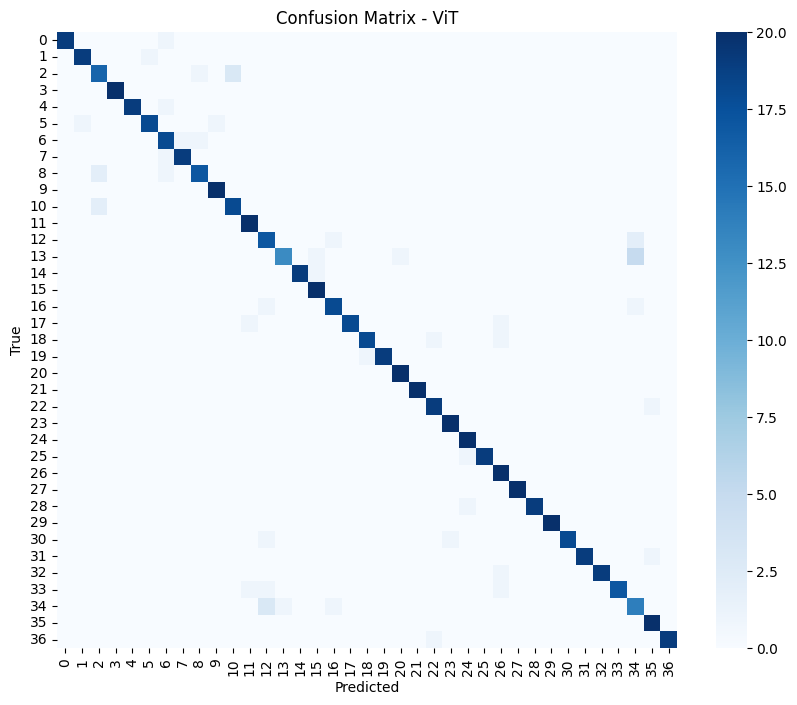

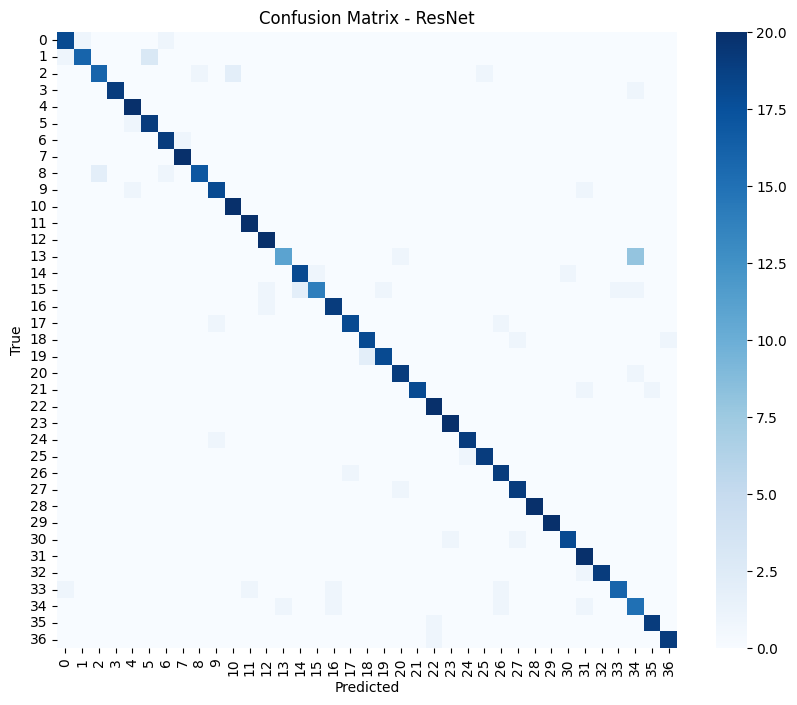

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(vit_y_true, vit_y_pred, title="ViT")
plot_confusion_matrix(resnet_y_true, resnet_y_pred, title="ResNet")
